In this notebook, we will analyze the data of Kickstarter, a crowdfunding platform that aims to "help bring creative projects to life". The data was originally from https://www.kaggle.com/datasets/kemical/kickstarter-projects?resource=download.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import holoviews as hv
import hvplot.pandas
import panel as pn
pn.extension()

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_df = pd.read_csv('kickstarter.csv')

### 1. Format

- change the format of columns, ``launched`` and ``deadline``, to datetime
- generate new columns to represent the ``year`` and ``month`` during which the project was ``launched``

In [3]:
# change the format of launched and deadline to datetime
data_df['launched'] = pd.to_datetime(data_df['launched'])
data_df['deadline'] = pd.to_datetime(data_df['deadline'])

In [4]:
# generate new columns to represent the year and month of launched
data_df['year'] = data_df['launched'].dt.year
data_df['month'] = data_df['launched'].dt.month

### 2. Noisy data
- find out data with noisy launched time 
- and decide whether you want to fix the noise or remove the noise

In [5]:
# find out the unique values of the column 'launched'
data_df['year'].unique()

array([2015, 2017, 2013, 2012, 2016, 2014, 2010, 2011, 2009, 1970, 2018],
      dtype=int64)

In [6]:
# remove the data with year of 1970
data_df = data_df[data_df['year'] != 1970]

### 3. Success rate

- Create a figure with two subplots (one column two rows) sharing
- Subplot 1: Use line chart to visualize the average success rate of projects (i.e., annual success rate) across years until 2017 (in other words, x-axis: year, y-axis: success rate)
- Subplot 2: Use a bar plot to display the number of projects per year (until 2017)

Text(0, 0.5, 'Number of Projects')

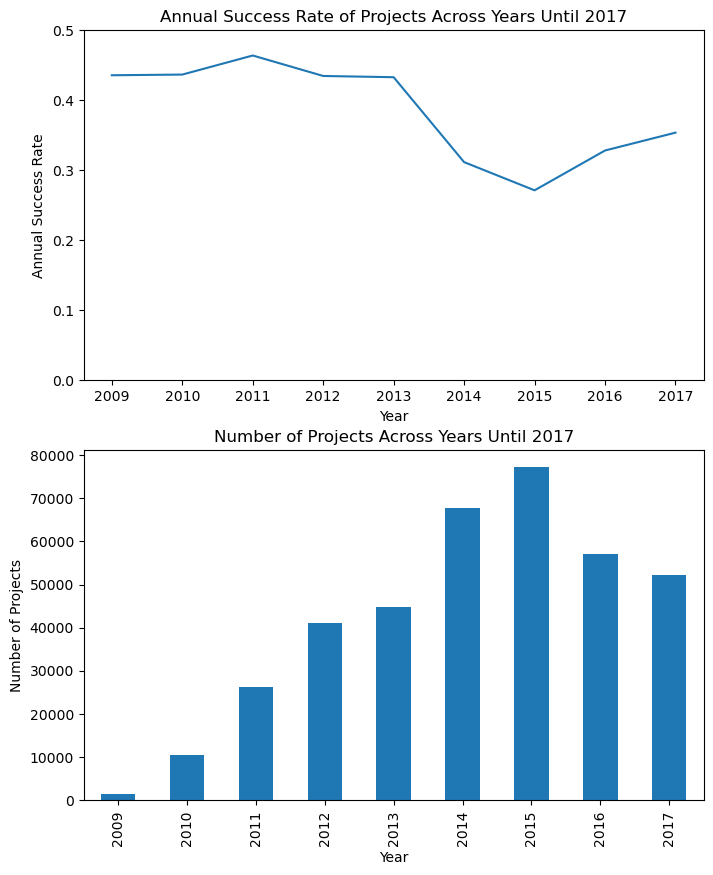

In [7]:
# create a figure with two subplots (one column and two rows)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))

# subplot 1: line chart to show the average success rate of projects across years until 2017
# generate a new dummy to represent the state of the project
data_df['success'] = data_df['state'].apply(lambda x: 1 if x == 'successful' else 0)
# group the data until 2017 by year and calculate the average success rate
data_df[data_df['year'] <= 2017].groupby('year')['success'].mean().plot(ax=axes[0])
axes[0].set_title('Annual Success Rate of Projects Across Years Until 2017')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Annual Success Rate')
axes[0].set_ylim(0, 0.5)

# subplot 2: bar chart to show the number of projects across years until 2017
# group the data until 2017 by year and calculate the number of projects
data_df[data_df['year'] <= 2017].groupby('year')['ID'].count().plot(kind='bar', ax=axes[1])
axes[1].set_title('Number of Projects Across Years Until 2017')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Number of Projects')


### 4. Hypothesis and exploration

The hypothesis I have for why success rate varies across years and use visualizations to show preliminary results examining my hypothesis.

Hypothesis:
1. The year with a bigger number of projects will have a smaller success rate
2. The year with a higher average usd goal will have a smaller success rate

Visualization:

Text(0, 0.5, 'Average USD Goal')

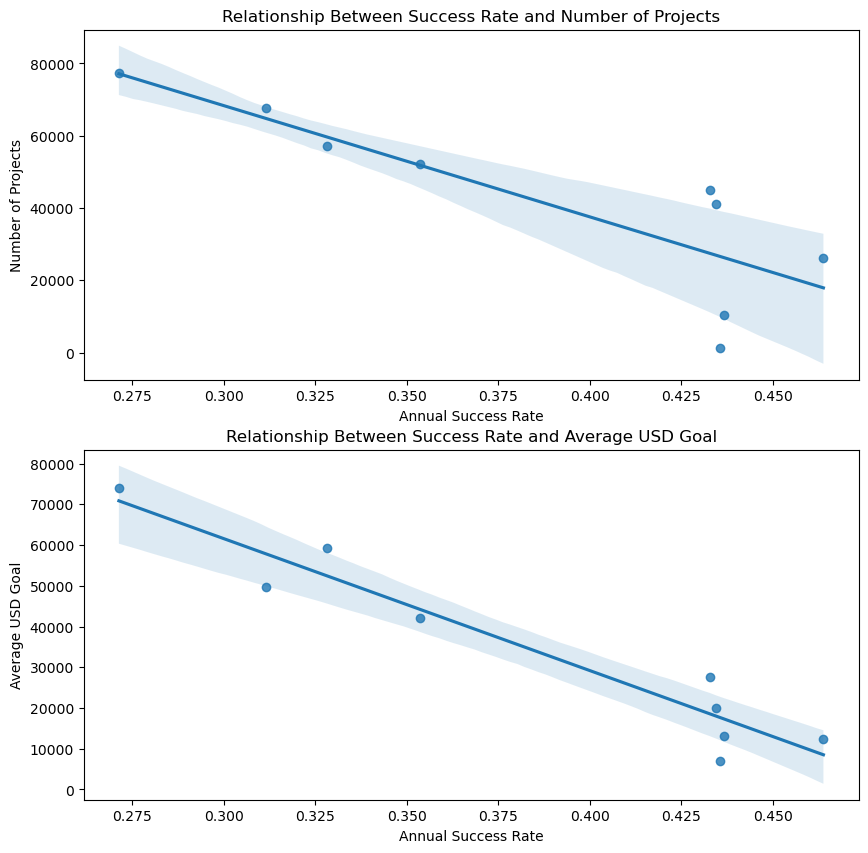

In [8]:
# generate a new dataframe to group the data until 2017 by year and calculate the average success rate
year_group = pd.DataFrame()
year_group[['year', 'annual_success_rate']] = data_df[data_df['year'] <= 2017].groupby('year')['success'].mean().reset_index()
# add a new column to represent the number of projects
year_group['num_projects'] = data_df[data_df['year'] <= 2017].groupby('year')['ID'].count().reset_index()['ID']
# add new columns to represent the average usd_goal_real for years until 2017
year_group['avg_usd_goal_real'] = data_df[data_df['year'] <= 2017].groupby('year')['usd_goal_real'].mean().reset_index()['usd_goal_real']

# generate scatter plots with fitted lines to show the relationship between the success rate and all other 2 variables
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
# subplot 1: relationship between success rate and number of projects
sns.regplot(x='annual_success_rate', y='num_projects', data=year_group, ax=axes[0])
axes[0].set_title('Relationship Between Success Rate and Number of Projects')
axes[0].set_xlabel('Annual Success Rate')
axes[0].set_ylabel('Number of Projects')
# subplot 2: relationship between success rate and average usd_goal_real
sns.regplot(x='annual_success_rate', y='avg_usd_goal_real', data=year_group, ax=axes[1])
axes[1].set_title('Relationship Between Success Rate and Average USD Goal')
axes[1].set_xlabel('Annual Success Rate')
axes[1].set_ylabel('Average USD Goal')

### 5. Interactive Dashboard

Build an interactive dashboard following the requirements below:
1. Could choose from one of the three countries: US, France (FR), United Kingdom of Great Britain and Northern Ireland (GB)
2. Has a slider to choose the year of the visualization
3. Could choose to visualize either the number of projects or the number of success projects (as y-axis)
4. Has a line chart to visualize the y-axis across months of the year

In [9]:
data_df.head(2)

,ID,name,category,main_category,country,currency,launched,deadline,goal,pledged,state,backers,usd_pledged_real,usd_goal_real,year,month,success
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GB,GBP,2015-08-11 12:12:28,2015-10-09,1000.0,0.0,failed,0,0.0,1533.95,2015,8,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,US,USD,2017-09-02 04:43:57,2017-11-01,30000.0,2421.0,failed,15,2421.0,30000.00,2017,9,0


In [10]:
# use RadioButtonGroup to select the country
country = pn.widgets.RadioButtonGroup(name='Country', options=['US', 'FR', 'GB'])
# use IntSlider to select the year
year = pn.widgets.IntSlider(name='Year', start=2009, end=2017, step=1, value=2017)
# use RadioButtonGroup to visualize either the number of projects or the number of successful projects as the y-axis
all_or_success = pn.widgets.RadioButtonGroup(name='All or Success Only', options=['All', 'Successful'])
# build an interactive dashboard for data_df
@pn.depends(country.param.value, year.param.value, all_or_success.param.value)
def get_plot(country, year, all_or_success):
    # filter the data by country and year
    data = data_df[(data_df['country'] == country) & (data_df['year'] == year)]
    # generate a new dataframe to group the data by month and calculate the number of projects
    data_group = pd.DataFrame()
    data_group['month'] = data.groupby('month')['ID'].count().reset_index()['month']
    data_group['num_projects'] = data.groupby('month')['ID'].count().reset_index()['ID']
    # generate a new dataframe to group the data by month and calculate the number of successful projects
    data_group_success = pd.DataFrame()
    data_group_success['month'] = data.groupby('month')['ID'].count().reset_index()['month']
    data_group_success['num_success'] = data[data['state'] == 'successful'].groupby('month')['ID'].count().reset_index()['ID']
    # merge the two dataframes
    data_group = pd.merge(data_group, data_group_success, on='month', how='left')
    # generate a line chart to show the number of projects or successful projects across months
    if all_or_success == 'All':
        return data_group.hvplot.line(x='month', y='num_projects', xlabel='Month', ylabel='Number of Projects', title='Number of Projects Across Months')
    else:
        return data_group.hvplot.line(x='month', y='num_success', xlabel='Month', ylabel='Number of Success Projects', title='Number of Success Projects Across Months')

# build the dashboard
dashboard = pn.Column(pn.Row(country, year, all_or_success), get_plot)
dashboard.servable()

BokehModel(combine_events=True, render_bundle={'docs_json': {'f0260075-04d1-493a-aad4-fc27dfe0cdfd': {'version…